# T2 mapping

### optional: for parallel computation

In [1]:
# addprocs(Sys.CPU_CORES-nprocs());
# nprocs()

### Loading juila packages

This cell only needs to run once when you start the kernel & this notebook

In [2]:
push!(LOAD_PATH,"library");
using Read_NIfTI1_real
using PyPlot
using NK_tools

### Loading NIfTI file

In [3]:
filename = "data/T2data.nii.gz";
headerinfo = load_niigz_header(filename); 
data = load_niigz_data(filename, headerinfo); # see the source code in library/Read_NIfTI1_real.jl
println("data size : ", size(data))
print("type of data: ", typeof(data))

data size : (192, 192, 4, 11)
type of data: Array{Int16,4}

### Displaying a single slice (e.g., slice # 3) corresponding a certain TE (e.g., the fourth echo)

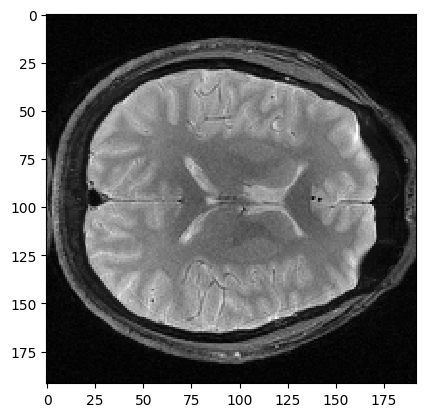

In [4]:
imshow(data[:,:,3,4],cmap="gray", interpolation="none"); # part of PyPlot

### Displaying multiple echoes (in 4 x 3 subplots) for slice #3

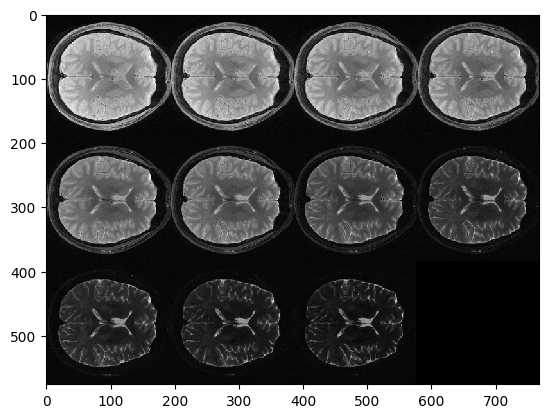

884736

In [5]:
imal(data[:,:,3,:],4,3); # see the source codes in library/NK_tools.jl

###  Converting data to double float format for further analysis

In [6]:
dataDouble = convert(Array{Float64},data);
println("type of data: ", typeof(dataDouble))

type of data: Array{Float64,4}


### T2 fitting for a single voxel (e.g., dataDouble[51,67,3,:] )

* TE value in T2data: 
    [10500.0, 15000.0, 20000.0, 25000.0, 35000.0, 40000.0, 60000.0, 80000.0, 100000.0, 120000.0, 140000.0];

* TE values in in T2stardata: 
    [10000.0, 15000.0, 20000.0, 25000.0, 30000.0, 35000.0, 40000.0, 60000.0, 80000.0, 100000.0, 120000.0, 140000.0]
* Use mricron to select your voxel [https://www.nitrc.org/projects/mricron]


71555.44886031868

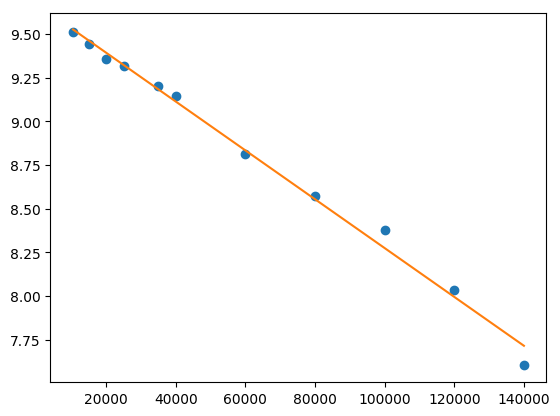

In [7]:
data1D = dataDouble[51,67,3,:];
TEvalue = [10500.0, 15000.0, 20000.0, 25000.0, 35000.0, 40000.0, 60000.0, 80000.0, 100000.0, 120000.0, 140000.0];
# figure(1); plot(TEvalue, data1D)
X = zeros(size(data)[4],2); 
X[:,1] = TEvalue;  X[:,2] = 1.0
coeff = X\log.(data1D)
figure(1); plot(TEvalue, log.(data1D),"o"), plot(TEvalue, coeff[1]*TEvalue + coeff[2]);
display(-1/coeff[1])

### T2 mapping

* TE value in T2data: 
    [10500.0, 15000.0, 20000.0, 25000.0, 35000.0, 40000.0, 60000.0, 80000.0, 100000.0, 120000.0, 140000.0];

* TE values in in T2stardata: 
    [10000.0, 15000.0, 20000.0, 25000.0, 30000.0, 35000.0, 40000.0, 60000.0, 80000.0, 100000.0, 120000.0, 140000.0]


In [8]:
T2map = zeros(size(data)[1],size(data)[2],size(data)[3]);
# T2map = SharedArray{Float64,3}((size(data)[1],size(data)[2],size(data)[3])); # this is for parallel computation
TEvalue = [10500.0, 15000.0, 20000.0, 25000.0, 35000.0, 40000.0, 60000.0, 80000.0, 100000.0, 120000.0, 140000.0];
X = zeros(size(data)[4],2); 
X[:,1] = TEvalue;  X[:,2] = 1.0
# @sync @parallel for cntz = 1:size(data)[3]
for cntz = 1:size(data)[3]
    for cnty = 1:size(data)[2]
        for cntx = 1:size(data)[1]
            data1D = dataDouble[cntx,cnty,cntz,:];
            coeff = X\log.(data1D)
            T2map[cntx,cnty,cntz]=-1/coeff[1];
        end
    end
end

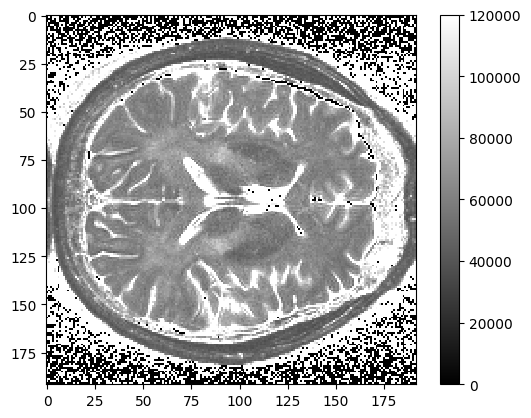

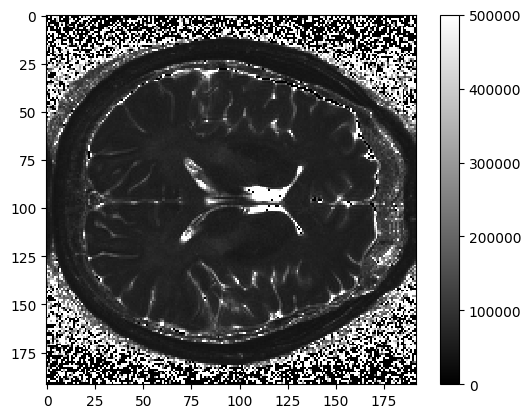

PyObject <matplotlib.colorbar.Colorbar object at 0x7fc19759c8d0>

In [9]:
figure(1); imshow(T2map[:,:,3],vmin=0,vmax=120000,cmap="gray",interpolation="none");colorbar()
figure(2); imshow(T2map[:,:,3],vmin=0,vmax=500000,cmap="gray",interpolation="none");colorbar()

### Saving T2 map to a NIFTI file

In [10]:
T2mapInt = deepcopy(T2map);
L = find(T2mapInt.>1000000);
T2mapInt[L] = 1000000;
L = find(T2mapInt.<0);
T2mapInt[L] = 0;
headerinfo["cal_max"] = Float32(200000);
headerinfo["cal_min"] = Float32(0);
headerinfo["datatype"] = Int16(16)
T2mapInt = convert(Array{Float32,3}, T2mapInt)
newFileName = "data/T2map.nii"
headerinfo["dim"][1:5]=[3,size(T2map)[1],size(T2map)[2],size(T2map)[3],1]
write_nii_header(newFileName, headerinfo);
fid = open(newFileName,"a");
write(fid, T2mapInt);
close(fid);

# Homework

### Homework for psychology students
* Measure the T2 values of gray-matter, white-matter, and CSF
* Critically review this [paper](http://onlinelibrary.wiley.com/doi/10.1002/mrm.1910140108/abstract) and produce figures that are similar to FIG 1a 1b and FIG 2 of the paper
* Display T1-weighted images and T2*-weighted images in the data directory; and discuss the image contrast

### Homework for engineering and medical physics students
* Measure the T2 values of gray-matter, white-matter, and CSF
* Calculate and save proton density maps
* Interpret and simulate MRI signals (0 to 120 msec after a 90-degree RF pulse excitation) based on these equations Robert W. Brown's MRI text book: ![Block equations](data/Bloch_equations.jpeg)

# Homework results

## 1. Measure T2 values of gray matter, white matter, and CSF

Voxels were selected by visual inspection of the T2 data series using the Mrtrix3 'mrview' tool. A linear fit was performed over all 11 TE values to obtain T2 values for each voxel for each tissue type. The T2 value for gray matter agrees with that found in the literature (~80 ms), while the values obtained for white matter and CSF were less in agreement.

"T2 for gray matter = 82.0499185357111 ms"

"T2 for white matter = 73.19104347626329 ms"

"T2 for CSF = 199.27615961400016 ms"

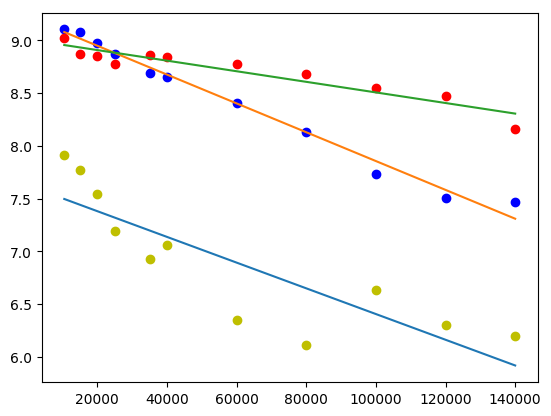

In [11]:
#Voxels selected by visual inspection of T2 images using Mrtrix3
grayVoxels = dataDouble[50,149,2,:];
whiteVoxels = dataDouble[62,66,2,:];
csfVoxels = dataDouble[94,112,2,:];

coeffGray = X\log.(grayVoxels);
coeffWhite = X\log.(whiteVoxels);
coeffCSF = X\log.(csfVoxels);

figure(1); plot(TEvalue, log.(grayVoxels),"yo"), plot(TEvalue, coeffGray[1]*TEvalue + coeffGray[2]);
display("T2 for gray matter = $(-.001/coeffGray[1]) ms");

figure(1); plot(TEvalue, log.(whiteVoxels),"bo"), plot(TEvalue, coeffWhite[1]*TEvalue + coeffWhite[2]);
display("T2 for white matter = $(-.001/coeffWhite[1]) ms");

figure(1); plot(TEvalue, log.(csfVoxels),"ro"), plot(TEvalue, coeffCSF[1]*TEvalue + coeffCSF[2]);
display("T2 for CSF = $(-.001/coeffCSF[1]) ms");

## 2. Calculate and save proton density maps

Proton density maps for each slice were obtained using data from the first TE and the above calculated T2 maps:
![Pd_map](data/Pd_Map.jpg)


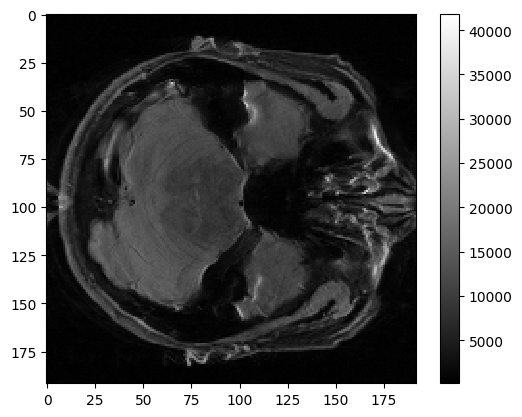

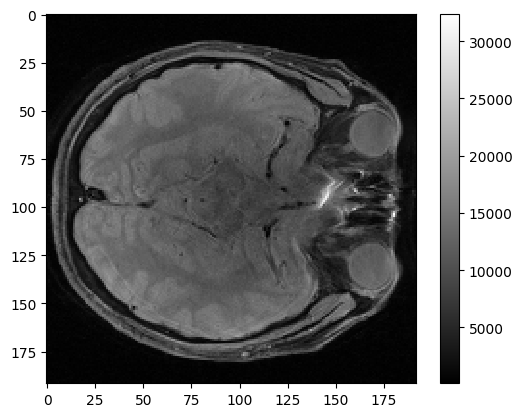

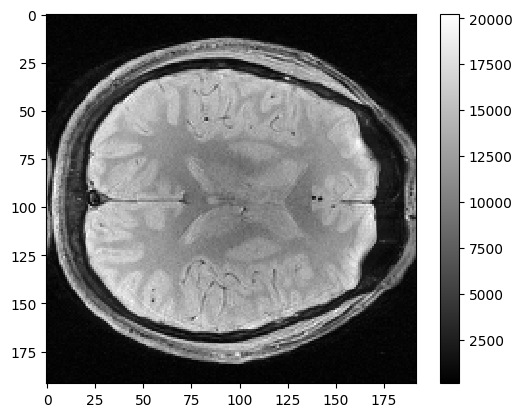

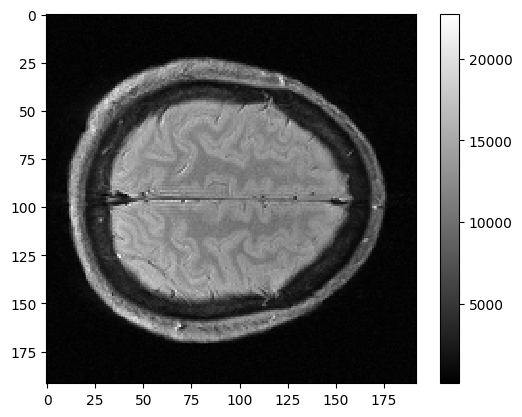

In [12]:
pdMap = 0*dataDouble;
dataTE1 = dataDouble[:,:,:,1];
TE1 = TEvalue[1];
pdMap = dataTE1./(exp.(-TE1./T2map));
figure(1); imshow(pdMap[:,:,1],cmap="gray");colorbar();
figure(2); imshow(pdMap[:,:,2],cmap="gray");colorbar();
figure(3); imshow(pdMap[:,:,3],cmap="gray");colorbar();
figure(4); imshow(pdMap[:,:,4],cmap="gray");colorbar();


Save off PD maps in NIFTI format:


In [13]:
pdMapInt = deepcopy(pdMap);
L = find(pdMapInt.>1000000);
pdMapInt[L] = 1000000;
L = find(pdMapInt.<0);
pdMapInt[L] = 0;
headerinfo["cal_max"] = Float32(200000);
headerinfo["cal_min"] = Float32(0);
headerinfo["datatype"] = Int16(16)
pdMapInt = convert(Array{Float32,3}, pdMapInt)
newFileName = "data/pdMap.nii"
headerinfo["dim"][1:5]=[3,size(pdMap)[1],size(pdMap)[2],size(pdMap)[3],1]
write_nii_header(newFileName, headerinfo);
fid = open(newFileName,"a");
write(fid, pdMapInt);
close(fid);

## 3. Interpret and simulate MR signal model

**Interpretation:** Each of the three equations describes the dynamics of a component of the net magnetization vector of a sample. The Mx and My components describe the transverse components of magnetization as they precess around the B0 vector, while the Mz component describes the longitudinal behavior of magnetization. 

**Simulation:** Each of the three equations was seeded with notional values of T1, T2, B0, etc, with the results plotted in 3-space. Note that a false value of the gyromagnetic ratio was used for this simulation in order to make the picture coherent - precession about B0 should actually occur at a much higher frequency.

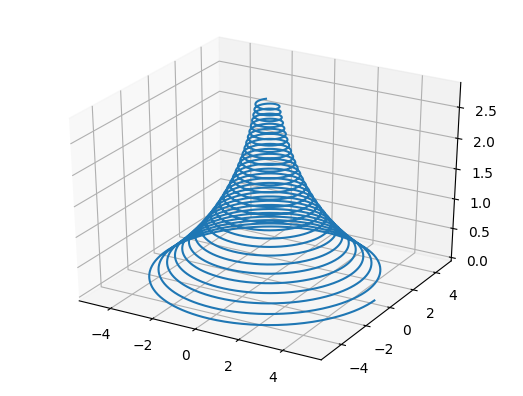

In [14]:
Mx0 = 5; #Initial alignment with x-axis
My0 = 0;
Mz0 = 0; #Since 90 degree pulse was used
M0 = 10;
gamma = 1; #(Fake) Gyromagnetic ratio, Hz/T
B0 = 1.5; # B0 field
omega0 = gamma*B0; #Precession frequency in MHz
T1 = 360; #T1 of gray matter at 1.5 T
T2 = 50; #T2 of gray matter at 1.5 T
tMax = 120; #End of simulation in ms
nPoints = 10000; #Number of simulation points

t = linspace(0,tMax,nPoints);
Mx = exp.(-t/T2).*(Mx0*cos.(omega0*t) + My0*sin.(omega0*t));
My = exp.(-t/T2).*(My0*cos.(omega0*t) - Mx0*sin.(omega0*t));
Mz = Mz0*exp.(-t/T1) + M0*(1-exp.(-t/T1));
plt = plot3D(Mx, My, Mz);

# Potential research projects
* Dual exponential fitting in white-matter and gray-matter ROIs